In [1]:
# import libraries
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier

sns.set_theme()
sns.set_palette('colorblind')

# GMM as a density estimator algorithm

http://ethen8181.github.io/machine-learning/clustering/GMM/GMM.html#Parameter-Estimation

## Q1: Download data

In [382]:
points, label = datasets.make_moons(n_samples=3000, noise=0.1, random_state=5)
df = pd.DataFrame(points, columns=['x', 'y'])
df['label'] = label
df.head()

,x,y,label
0,1.826680,0.196675,1
1,1.977349,-0.078841,1
2,1.936948,-0.038648,1
3,0.078785,0.199561,1
4,0.285802,-0.354202,1


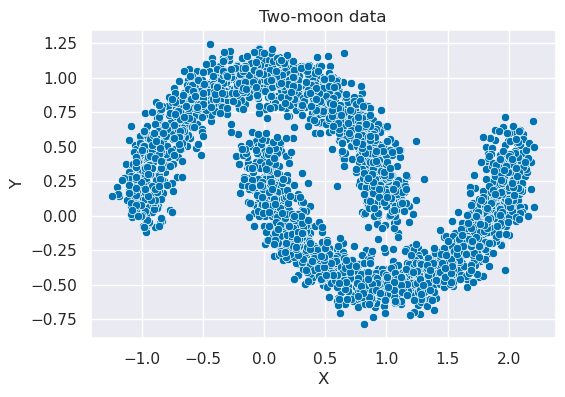

In [383]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x='x', y='y', ax=ax).set(title='Two-moon data', xlabel='X', ylabel='Y')
# plt.savefig('viz/1a.png', bbox_inches='tight')
plt.show()

## Q2: Plot level sets

In [384]:
# fit gaussian mixture
gm = GaussianMixture(n_components=2, random_state=0).fit(df[['x', 'y']])

k = gm.means_.shape[0]
x = np.linspace(-1.5, 2.5)
y = np.linspace(-1.0, 1.5)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

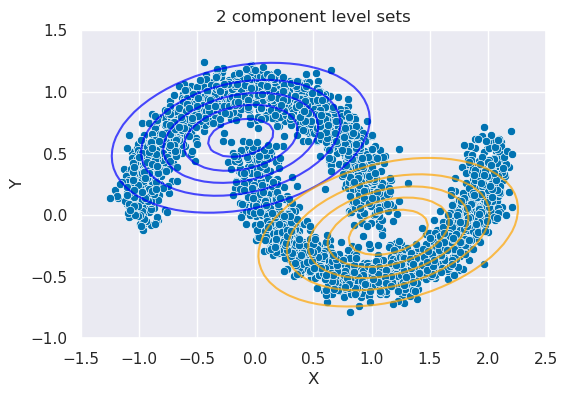

In [6]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x='x', y='y', ax=ax).set(title='2 component level sets', xlabel='X', ylabel='Y')

colors = ['blue', 'orange']
for i in range(k):
    mean = gm.means_[i]
    cov = gm.covariances_[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
    ax.contour(x_grid, y_grid, z_grid, colors=colors[i], alpha=0.7)

# fig.savefig('viz/1b.png', bbox_inches='tight')

## Q4: GridSearchCV - Find the optimal number of components

In [305]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(df[['x', 'y']], df['label'], test_size=0.2, stratify=label, random_state=0)

train_data = X_train.copy()
test_data = X_test.copy()

train_data['label'] = y_train
test_data['label'] = y_test

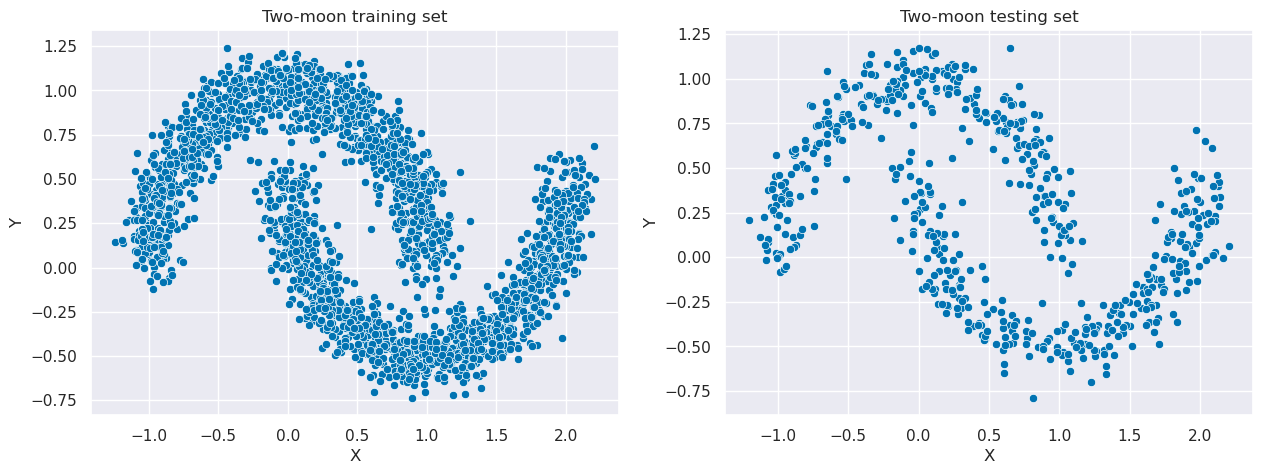

In [306]:
# plot train data and test data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.scatterplot(data=train_data, x='x', y='y', ax=ax1).set(title='Two-moon training set', xlabel='X', ylabel='Y')
sns.scatterplot(data=test_data, x='x', y='y', ax=ax2).set(title='Two-moon testing set', xlabel='X', ylabel='Y')
# plt.savefig('viz/1d_train_test.png', bbox_inches='tight')
plt.show()

In [307]:
# define scoring cretia
def bic_score(estimator, X):
    return -estimator.bic(X) # negative because GridSearchCV is searching for a score to maximize

# grid search
params = {
    'n_components': range(2,16),
    'covariance_type': ['full', 'tied']
}

grid_search_cv =  GridSearchCV(estimator=GaussianMixture(), param_grid=params, scoring=bic_score)
grid_search_cv.fit(X_train)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied'],
                         'n_components': range(2, 16)},
             scoring=<function bic_score at 0x7f05461a4e00>)

In [308]:
# best estimator
grid_search_cv.best_estimator_

GaussianMixture(n_components=6)

In [309]:
grid_df = pd.DataFrame(grid_search_cv.cv_results_)[['param_n_components', 'param_covariance_type', 'mean_test_score']]

grid_df['mean_test_score'] = -grid_df['mean_test_score']
grid_df = grid_df.rename(columns={'param_n_components': 'Number of components',
                                  'param_covariance_type': 'Type of covariance',
                                  'mean_test_score': 'BIC score'})

grid_df.sort_values(by='BIC score').head()

,Number of components,Type of covariance,BIC score
4,6,full,1297.073473
5,7,full,1305.948867
6,8,full,1319.567403
7,9,full,1339.667238
27,15,tied,1360.086445


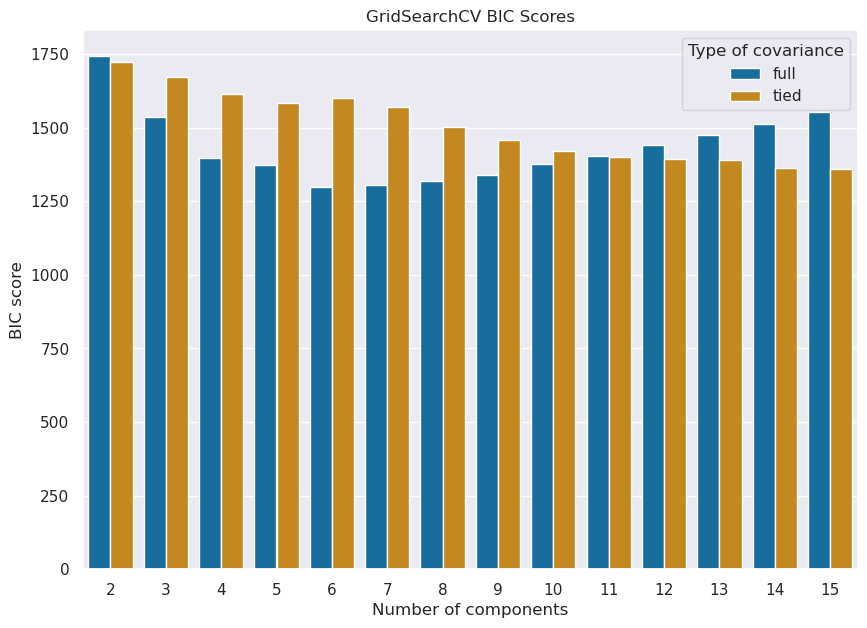

In [310]:
fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(data=grid_df, x='Number of components', y='BIC score', hue='Type of covariance', ax=ax).set(title='GridSearchCV BIC Scores')
# plt.savefig('viz/1d_grid_results.png', bbox_inches='tight')
plt.show()

### Plot the level sets of optimal number of components 

In [311]:
gm = grid_search_cv.best_estimator_.fit(X_train)

k = gm.means_.shape[0]
x = np.linspace(-1.5, 2.5, num=200)
y = np.linspace(-1.0, 1.5, num=200)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

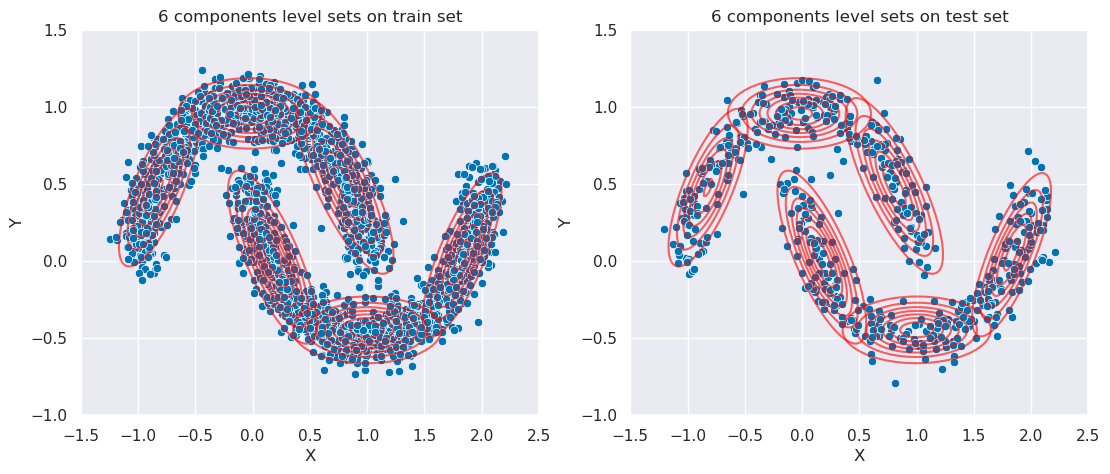

In [313]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
sns.scatterplot(data=train_data, x='x', y='y', ax=ax1).set(title='6 components level sets on train set', xlabel='X', ylabel='Y')
for i in range(k):
    mean = gm.means_[i]
    cov = gm.covariances_[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
    ax1.contour(x_grid, y_grid, z_grid, colors='red', alpha=0.6)

sns.scatterplot(data=test_data, x='x', y='y', ax=ax2).set(title='6 components level sets on test set', xlabel='X', ylabel='Y')
for i in range(k):
    mean = gm.means_[i]
    cov = gm.covariances_[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
    ax2.contour(x_grid, y_grid, z_grid, colors='red', alpha=0.6)

# fig.savefig('viz/1d.png', bbox_inches='tight')

# GMM as a classifier

## Q1: Plot data with label

In [2]:
points, label = datasets.make_moons(n_samples=3000, noise=0.1, random_state=5)
df = pd.DataFrame(points, columns=['x', 'y'])
df['label'] = label

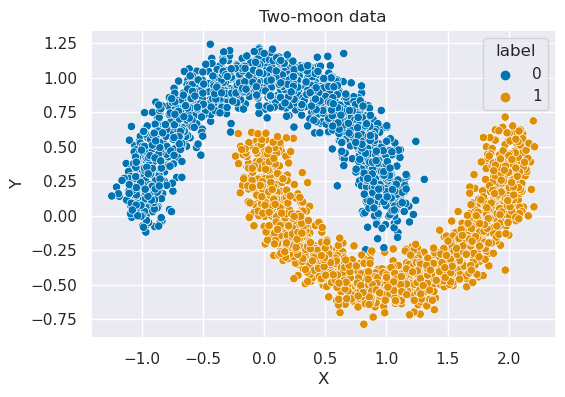

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x='x', y='y', hue='label', ax=ax).set(title='Two-moon data', xlabel='X', ylabel='Y')
# plt.savefig('viz/2a.png', bbox_inches='tight')
plt.show()

## Q2

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[['x', 'y']], df['label'], test_size=0.2, stratify=df['label'], random_state=0)
train_data = X_train.copy()
test_data = X_test.copy()
train_data['label'] = y_train
test_data['label'] = y_test

In [5]:
gm = GaussianMixture(n_components=2, random_state=0).fit(X_train)

In [6]:
y_pred = gm.predict(X_test)
y_pred

array([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [7]:
gm_result = test_data.copy()
gm_result['pred_label'] = y_pred
gm_result.head()

,x,y,label,pred_label
2335,0.689330,0.668005,0,1
2400,0.073388,0.531035,1,1
95,0.018138,0.360448,1,1
2234,1.959510,0.258251,1,0
1757,0.743640,0.770920,0,1


In [8]:
k = gm.means_.shape[0]
x = np.linspace(-1.5, 2.5, num=200)
y = np.linspace(-1.0, 1.5, num=200)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

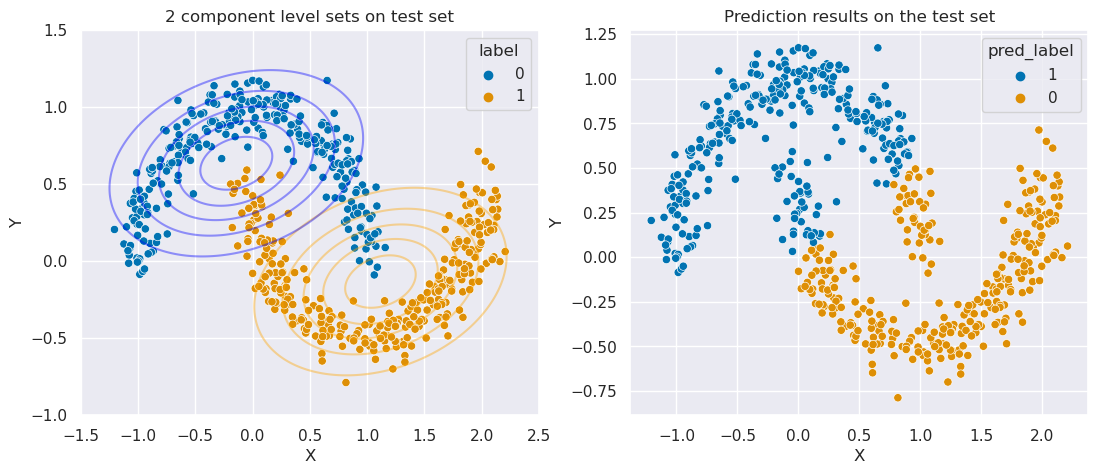

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

sns.scatterplot(data=test_data, x='x', y='y', hue='label', ax=ax1).set(title='2 component level sets on test set',
                                                                       xlabel='X', ylabel='Y')
colors = ['orange', 'blue']
for i in range(k):
    mean = gm.means_[i]
    cov = gm.covariances_[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
    ax1.contour(x_grid, y_grid, z_grid, colors=colors[i], alpha=0.4)

sns.scatterplot(data=gm_result, x='x', y='y', hue='pred_label', hue_order=[1,0], ax=ax2).set(title='Prediction results on the test set',
                                                                                             xlabel='X', ylabel='Y')
# plt.savefig('viz/2b.png', bbox_inches='tight')
plt.show()

## Q3 and Q4

In [322]:
X_train, X_test, y_train, y_test = train_test_split(df[['x', 'y']], df['label'], test_size=0.2, stratify=df['label'], random_state=0)
train_data = X_train.copy()
test_data = X_test.copy()
train_data['label'] = y_train
test_data['label'] = y_test

In [323]:
gm = GaussianMixture(n_components=4, covariance_type='full', random_state=0).fit(X_train)

k = gm.means_.shape[0]
x = np.linspace(-1.5, 2.5, num=200)
y = np.linspace(-1.0, 1.5, num=200)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

label0 = train_data[train_data['label']==0]
label1 = train_data[train_data['label']==1]

In [324]:
component_labels = []
for i in range(gm.means_.shape[0]):
    score0 = np.mean(multivariate_normal.pdf(label0[['x', 'y']], gm.means_[i], gm.covariances_[i]))
    score1 = np.mean(multivariate_normal.pdf(label1[['x', 'y']], gm.means_[i], gm.covariances_[i]))
    if score0 > score1:
        component_labels.append(0)
    else:
        component_labels.append(1)
component_labels

[1, 0, 1, 0]

In [325]:
y_pred = gm.predict(X_test)

y_pred_label = []
for x in y_pred:
    y_pred_label.append(component_labels[x])

test_data['pred_label'] = y_pred_label
test_data.head()

,x,y,label,pred_label
2335,0.689330,0.668005,0,0
2400,0.073388,0.531035,1,1
95,0.018138,0.360448,1,1
2234,1.959510,0.258251,1,1
1757,0.743640,0.770920,0,0


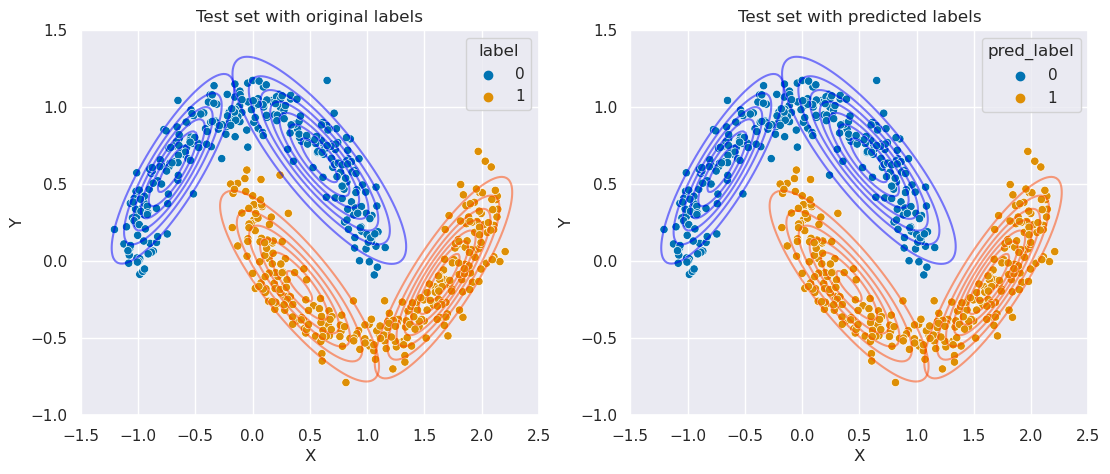

In [326]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

sns.scatterplot(data=test_data, x='x', y='y', hue='label', ax=ax1).set(title='Test set with original labels',
                                                                       xlabel='X', ylabel='Y')
cls = ['blue', 'orangered']
for i in range(k):
    mean = gm.means_[i]
    cov = gm.covariances_[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
    ax1.contour(x_grid, y_grid, z_grid, colors=cls[component_labels[i]], alpha=0.5)

sns.scatterplot(data=test_data, x='x', y='y', hue='pred_label', ax=ax2).set(title='Test set with predicted labels',
                                                                           xlabel='X', ylabel='Y')
cls = ['blue', 'orangered']
for i in range(k):
    mean = gm.means_[i]
    cov = gm.covariances_[i]
    z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
    ax2.contour(x_grid, y_grid, z_grid, colors=cls[component_labels[i]], alpha=0.5)

# plt.savefig('viz/2d.png', bbox_inches='tight')
plt.show()

In [327]:
accuracy_score(y_test, y_pred_label)

0.9983333333333333

## Q5

In [283]:
scores = {}
label0 = train_data[train_data['label']==0]
label1 = train_data[train_data['label']==1]

x = np.linspace(-1.5, 2.5, num=200)
y = np.linspace(-1.0, 1.5, num=200)
x_grid, y_grid = np.meshgrid(x, y)
coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

for n in range(2, 16):
    for cov_type in ['full', 'tied']:
        gm = GaussianMixture(n_components=n, covariance_type=cov_type, random_state=0).fit(X_train)

        k = gm.means_.shape[0]

        if cov_type == 'full':
            component_labels = []
            for i in range(gm.means_.shape[0]):
                score0 = np.mean(multivariate_normal.pdf(label0[['x', 'y']], gm.means_[i], gm.covariances_[i]))
                score1 = np.mean(multivariate_normal.pdf(label1[['x', 'y']], gm.means_[i], gm.covariances_[i]))
                if score0 > score1:
                    component_labels.append(0)
                else:
                    component_labels.append(1)
            y_pred = gm.predict(X_test)
            y_pred_label = []
            for x in y_pred:
                y_pred_label.append(component_labels[x])
        else:
            component_labels = []
            for i in range(gm.means_.shape[0]):
                score0 = np.mean(multivariate_normal.pdf(label0[['x', 'y']], gm.means_[i], gm.covariances_))
                score1 = np.mean(multivariate_normal.pdf(label1[['x', 'y']], gm.means_[i], gm.covariances_))
                if score0 > score1:
                    component_labels.append(0)
                else:
                    component_labels.append(1)
            y_pred = gm.predict(X_test)
            y_pred_label = []
            for x in y_pred:
                y_pred_label.append(component_labels[x])
        
        scores[n, cov_type] = (accuracy_score(y_test, y_pred_label))

In [291]:
scores

{(2, 'full'): 0.865,
 (2, 'tied'): 0.8666666666666667,
 (3, 'full'): 0.72,
 (3, 'tied'): 0.8383333333333334,
 (4, 'full'): 0.9983333333333333,
 (4, 'tied'): 0.84,
 (5, 'full'): 0.995,
 (5, 'tied'): 0.8166666666666667,
 (6, 'full'): 0.9966666666666667,
 (6, 'tied'): 0.9733333333333334,
 (7, 'full'): 0.9983333333333333,
 (7, 'tied'): 0.9783333333333334,
 (8, 'full'): 0.9983333333333333,
 (8, 'tied'): 0.9833333333333333,
 (9, 'full'): 0.9983333333333333,
 (9, 'tied'): 0.995,
 (10, 'full'): 0.9983333333333333,
 (10, 'tied'): 0.995,
 (11, 'full'): 1.0,
 (11, 'tied'): 0.9983333333333333,
 (12, 'full'): 1.0,
 (12, 'tied'): 0.9983333333333333,
 (13, 'full'): 1.0,
 (13, 'tied'): 0.9983333333333333,
 (14, 'full'): 1.0,
 (14, 'tied'): 1.0,
 (15, 'full'): 1.0,
 (15, 'tied'): 1.0}

## Q6

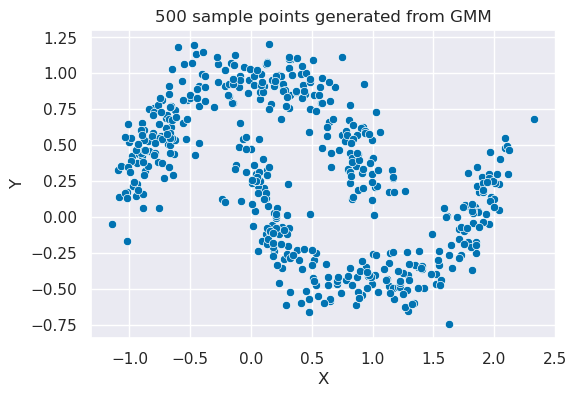

In [93]:
fig, ax = plt.subplots(figsize=(6,4))
sns.scatterplot(x=gm.sample(500)[0][:, 0], y=gm.sample(500)[0][:, 1]).set(title='500 sample points generated from GMM',
                                                                       xlabel='X', ylabel='Y')
# plt.savefig('viz/2g.png', bbox_inches='tight')
plt.show()

# GMM on the MNIST dataset as a generative model

## Q1

In [168]:
digits = datasets.load_digits()
# digits.data = normalize(digits.data)

digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [169]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [170]:
pca = PCA(n_components=0.95).fit(digits.data)
pca.n_components_

29

In [171]:
digits.data = pca.transform(digits.data)
digits.data[0]

array([-1.25946645, 21.27488348, -9.46305462, 13.01418869, -7.12882278,
       -7.44065876,  3.25283716,  2.55347036, -0.58184214,  3.62569695,
        2.58595688,  1.55160708,  0.85449671, -3.33874935,  5.90658968,
        2.74359339,  0.41983691, -0.89814969,  0.70261087, -3.46211868,
        2.68084958,  1.00944951,  2.00970276,  1.29531479,  1.17887873,
        2.30058185,  3.67072108, -0.9436689 , -1.13250195])

## Q2

In [172]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=0)

## Density estimator

In [173]:
def bic_score(estimator, X):
    return -estimator.bic(X) # negative because GridSearchCV is searching for a score to maximize

# grid search
params = {
    'n_components': range(1,21),
    'covariance_type': ['full', 'tied']
}

grid_search_cv =  GridSearchCV(estimator=GaussianMixture(), param_grid=params, scoring=bic_score)
grid_search_cv.fit(X_train)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['full', 'tied'],
                         'n_components': range(1, 21)},
             scoring=<function bic_score at 0x7fe654f6f560>)

In [174]:
grid_search_cv.best_estimator_

GaussianMixture(covariance_type='tied', n_components=8)

In [175]:
grid_search_cv.best_params_

{'covariance_type': 'tied', 'n_components': 8}

## Classifier

In [176]:
components_scores = {}
label0 = digits.data[digits.target == 0]
label1 = digits.data[digits.target == 1]
label2 = digits.data[digits.target == 2]
label3 = digits.data[digits.target == 3]
label4 = digits.data[digits.target == 4]
label5 = digits.data[digits.target == 5]
label6 = digits.data[digits.target == 6]
label7 = digits.data[digits.target == 7]
label8 = digits.data[digits.target == 8]
label9 = digits.data[digits.target == 9]

for n in range(10, 31):
    gm = GaussianMixture(n_components=n, random_state=0).fit(X_train)

    component_labels = []
    for i in range(gm.means_.shape[0]):
        scores = {}
        scores[0] = np.mean(multivariate_normal.pdf(label0, gm.means_[i], gm.covariances_[i]))
        scores[1] = np.mean(multivariate_normal.pdf(label1, gm.means_[i], gm.covariances_[i]))
        scores[2] = np.mean(multivariate_normal.pdf(label2, gm.means_[i], gm.covariances_[i]))
        scores[3] = np.mean(multivariate_normal.pdf(label3, gm.means_[i], gm.covariances_[i]))
        scores[4] = np.mean(multivariate_normal.pdf(label4, gm.means_[i], gm.covariances_[i]))
        scores[5] = np.mean(multivariate_normal.pdf(label5, gm.means_[i], gm.covariances_[i]))
        scores[6] = np.mean(multivariate_normal.pdf(label6, gm.means_[i], gm.covariances_[i]))
        scores[7] = np.mean(multivariate_normal.pdf(label7, gm.means_[i], gm.covariances_[i]))
        scores[8] = np.mean(multivariate_normal.pdf(label8, gm.means_[i], gm.covariances_[i]))
        scores[9] = np.mean(multivariate_normal.pdf(label9, gm.means_[i], gm.covariances_[i]))
        component_labels.append(max(scores, key=scores.get))
        
    y_pred = gm.predict(X_test)
    y_pred_label = []
    for x in y_pred:
        y_pred_label.append(component_labels[x])

    components_scores[n] = accuracy_score(y_test, y_pred_label)

In [177]:
components_scores

{10: 0.7805555555555556,
 11: 0.7805555555555556,
 12: 0.7944444444444444,
 13: 0.7916666666666666,
 14: 0.8222222222222222,
 15: 0.9222222222222223,
 16: 0.9138888888888889,
 17: 0.9194444444444444,
 18: 0.8944444444444445,
 19: 0.9,
 20: 0.8888888888888888,
 21: 0.9111111111111111,
 22: 0.8972222222222223,
 23: 0.9027777777777778,
 24: 0.8972222222222223,
 25: 0.8944444444444445,
 26: 0.8888888888888888,
 27: 0.8972222222222223,
 28: 0.875,
 29: 0.8777777777777778,
 30: 0.8611111111111112}

## Q3

In [178]:
gm = GaussianMixture(n_components=15, random_state=0).fit(X_train)

In [179]:
label0 = digits.data[digits.target == 0]
label1 = digits.data[digits.target == 1]
label2 = digits.data[digits.target == 2]
label3 = digits.data[digits.target == 3]
label4 = digits.data[digits.target == 4]
label5 = digits.data[digits.target == 5]
label6 = digits.data[digits.target == 6]
label7 = digits.data[digits.target == 7]
label8 = digits.data[digits.target == 8]
label9 = digits.data[digits.target == 9]

In [180]:
component_labels = []

for i in range(gm.means_.shape[0]):
    scores = {}
    scores[0] = np.mean(multivariate_normal.pdf(label0, gm.means_[i], gm.covariances_[i]))
    scores[1] = np.mean(multivariate_normal.pdf(label1, gm.means_[i], gm.covariances_[i]))
    scores[2] = np.mean(multivariate_normal.pdf(label2, gm.means_[i], gm.covariances_[i]))
    scores[3] = np.mean(multivariate_normal.pdf(label3, gm.means_[i], gm.covariances_[i]))
    scores[4] = np.mean(multivariate_normal.pdf(label4, gm.means_[i], gm.covariances_[i]))
    scores[5] = np.mean(multivariate_normal.pdf(label5, gm.means_[i], gm.covariances_[i]))
    scores[6] = np.mean(multivariate_normal.pdf(label6, gm.means_[i], gm.covariances_[i]))
    scores[7] = np.mean(multivariate_normal.pdf(label7, gm.means_[i], gm.covariances_[i]))
    scores[8] = np.mean(multivariate_normal.pdf(label8, gm.means_[i], gm.covariances_[i]))
    scores[9] = np.mean(multivariate_normal.pdf(label9, gm.means_[i], gm.covariances_[i]))
    component_labels.append(max(scores, key=scores.get))
    
component_labels

[7, 3, 6, 0, 1, 1, 9, 4, 2, 2, 0, 8, 4, 5, 5]

In [181]:
component_names_labels = {}

for x in range(len(component_labels)):
    component_names_labels[f'component{x}'] = component_labels[x]

component_names_labels

{'component0': 7,
 'component1': 3,
 'component2': 6,
 'component3': 0,
 'component4': 1,
 'component5': 1,
 'component6': 9,
 'component7': 4,
 'component8': 2,
 'component9': 2,
 'component10': 0,
 'component11': 8,
 'component12': 4,
 'component13': 5,
 'component14': 5}

In [182]:
y_pred = gm.predict(X_test)

y_pred_label = []
for x in y_pred:
    y_pred_label.append(component_labels[x])

## Q4

In [184]:
samples = gm.sample(100)
samples[0][0]

array([ -6.39728087, -17.88273906,  -7.75158325,  11.25285519,
       -11.48799622,   9.04887511,  -1.29225628,   5.96815645,
         5.30886657, -11.40353164, -11.19109756,   8.05300767,
         3.25216051,   9.39738119,   4.73926234,   2.59311294,
        -6.03275848,  -2.37754836,   4.18715962,  -3.44278225,
        -2.12716678,  -2.81668457,  -1.07246343,  -3.23354808,
         2.32002067,   2.05306549,   0.43762284,  -1.38253118,
         5.23339863])

In [185]:
samples[1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 14, 14, 14, 14, 14])

In [186]:
for x in range(len(samples[1])):
    samples[1][x] = component_labels[samples[1][x]]

samples[1]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8,
       8, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5])

In [187]:
original_data = pca.inverse_transform(samples[0])

In [188]:
df = pd.DataFrame(original_data)
df['label'] = samples[1]
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,-2.278453e-17,0.506111,8.710320,19.682410,13.471825,8.016155,7.548362,1.293771,-0.016052,1.542652,...,-0.252180,0.002404,0.627887,11.181442,14.468954,-2.659358,-1.126250,0.268349,-0.790147,7
1,-1.116070e-16,0.716590,9.878801,14.866373,17.595249,8.867563,-2.995779,-1.042693,-0.004351,3.818007,...,-0.594190,0.003709,0.724987,12.468274,8.522824,-3.460140,0.966556,-0.266775,-1.258662,7
2,-1.175646e-16,0.663501,8.153904,14.094993,11.371198,6.474649,0.829891,0.119103,0.034118,6.089142,...,-0.529561,-0.002351,0.436934,9.684922,11.547949,-0.045082,1.576226,-0.459445,-0.551962,7
3,-2.150018e-17,0.546970,5.309844,18.355509,17.829664,15.832714,10.149053,1.497536,0.006660,1.057089,...,0.315459,0.004475,0.503352,7.658292,16.683259,0.467933,-0.842217,0.401028,0.469343,7
4,5.213878e-18,-0.176864,1.232306,9.468489,11.562229,11.262050,5.597790,0.971144,0.005446,1.338358,...,0.243187,-0.002499,-0.228034,1.079741,13.061110,4.711135,-0.642006,-0.517681,-0.005353,7


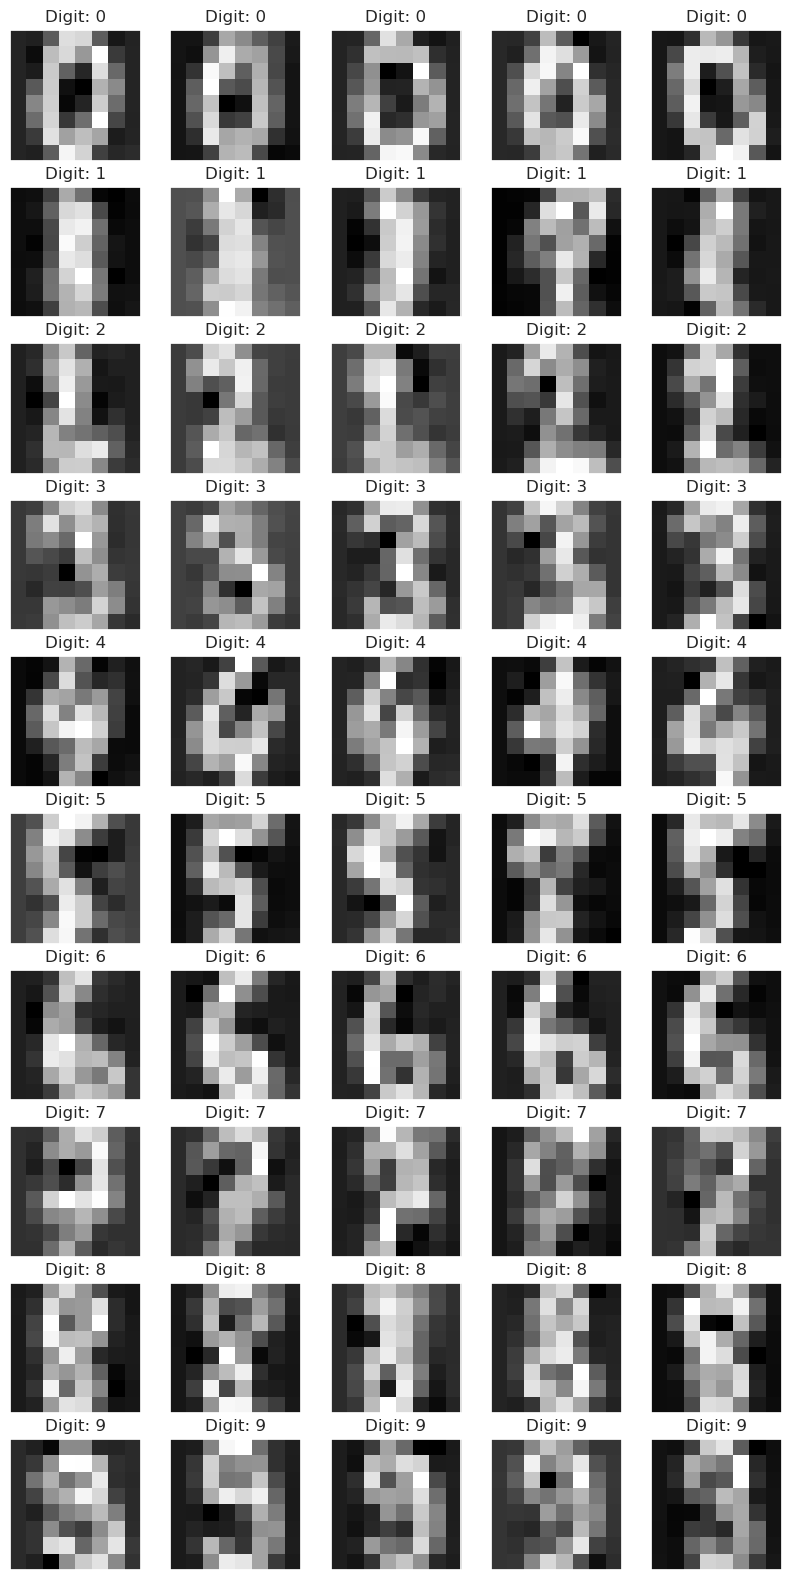

In [190]:
fig, axes = plt.subplots(nrows=10, ncols=5, sharex='all', sharey='all', figsize=(10, 20))

for i in range(0, 10):
    digits = df[df['label']==i].sample(5).drop('label', axis=1)
    x = 0
    for j in digits.index:
        axes[i,x].imshow(digits.loc[j].to_numpy().reshape(8,8), cmap='gray')
        axes[i,x].set_title(f'Digit: {i}')
        axes[i,x].grid(False)
        axes[i,x].set_xticks([])
        axes[i,x].set_yticks([])
        x += 1

# plt.savefig('viz/3d.png', bbox_inches="tight")
plt.show()

## Q5

In [198]:
digits2 = datasets.load_digits()
# digits2.data = normalize(digits2.data)
df = pd.DataFrame(digits2.data)
df['label'] = digits2.target
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [199]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.2, random_state=0)

In [200]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [201]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.9777777777777777


In [202]:
samples = gm.sample(1000)
for x in range(len(samples[1])):
    samples[1][x] = component_labels[samples[1][x]]

original_data = pca.inverse_transform(samples[0])

samples_df = pd.DataFrame(original_data)
samples_df['label'] = samples[1]
samples_df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,5.642816e-17,-0.095453,2.322389,10.161185,13.388860,18.060209,10.345789,1.795804,-0.029948,-2.419107,...,0.465981,0.002767,0.065909,3.396871,11.511030,2.901857,-0.165888,-0.695558,0.381054,7
1,-7.080349e-17,-0.057113,3.911518,10.488216,17.966416,18.171671,3.894616,0.520690,-0.006042,0.016792,...,-0.267639,0.000291,-0.091626,4.928762,10.813389,4.423920,1.901168,-1.388410,-0.980883,7
2,2.488260e-17,0.273864,8.179355,17.836881,14.174764,9.541909,6.167639,1.253994,-0.006880,0.463467,...,0.337684,-0.006882,0.174735,9.357212,17.850755,4.679236,-0.524343,0.622258,1.010708,7
3,-1.272825e-16,1.028231,9.680297,15.859030,17.132056,9.552652,1.515883,0.128729,0.016822,4.223240,...,-0.352475,0.000143,0.961508,12.132055,10.897319,0.846552,0.828509,-0.598364,-1.330205,7
4,2.504583e-17,0.096723,2.868673,9.992167,10.605255,18.144792,14.109779,2.723999,-0.005169,0.833082,...,0.038789,-0.001504,0.162329,3.201723,13.508987,2.750780,-0.138737,-0.350892,-0.470164,7


In [203]:
samples_y_pred = model.predict(samples_df.drop('label', axis=1))

accuracy = accuracy_score(samples[1], samples_y_pred)
print(f'Accuracy Score: {accuracy}')

Accuracy Score: 0.941
